In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [4]:
POS_DIR = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips'
NEG_DIR = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips'

In [5]:
wave = load_wav_16k_mono(os.path.join(POS_DIR, 'XC3776-0.wav'))
nwave = load_wav_16k_mono(os.path.join(NEG_DIR, 'Crickets-chirping-0.wav'))

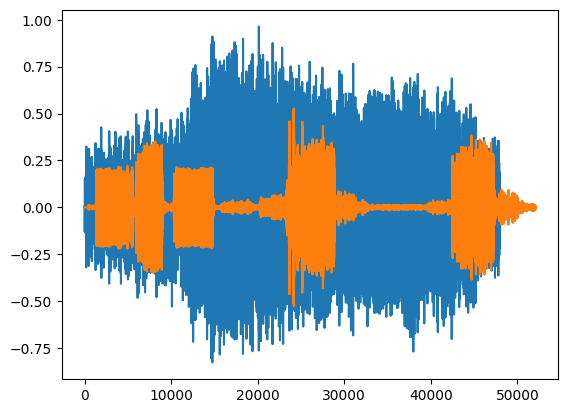

In [6]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [7]:
pos = tf.data.Dataset.list_files(POS_DIR+'/*.wav')
neg = tf.data.Dataset.list_files(NEG_DIR+'/*.wav')

In [8]:
pos.as_numpy_iterator().next()

b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC114132-0.wav'

In [9]:
# Add labels and combine positive and negative samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

In [10]:
data = positives.concatenate(negatives)

In [11]:
data.shuffle(buffer_size = 1000).as_numpy_iterator().next()

(b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/crickets-sound-effect-17.wav',
 0.0)

# Determine average length of capuchin call


In [12]:
# Calculate wave cycle length
lengths = []
for file in os.listdir(POS_DIR):
    tensor_wave = load_wav_16k_mono(os.path.join(POS_DIR, file))
    lengths.append(len(tensor_wave))

In [ ]:
lengths

In [14]:
# Take mean, min and max
print(f"Mean length of capuchine bird call: {tf.math.reduce_mean(lengths)/16000} seconds")
print(f"Min length of capuchine bird call: {tf.math.reduce_min(lengths)/16000} seconds")
print(f"Max length of capuchine bird call: {tf.math.reduce_max(lengths)/16000} seconds")

Mean length of capuchine bird call: 3.38475 seconds
Min length of capuchine bird call: 2.0 seconds
Max length of capuchine bird call: 5.0 seconds


# Convert to spectrogram

In [15]:
# Preprocessing function
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    # Taking 48000 steps (close to the mean = tf.math.reduce_mean(lengths))
    wav = wav[:48000]
    # If length of clip is less than 48000, pad it with zeros at the start
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype = tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis = 2)
    return spectrogram, label

# Test out the function and visualize spectrogram

In [23]:
filepath, label = positives.shuffle(buffer_size = 10000).as_numpy_iterator().next()

In [24]:
spectrogram, label = preprocess(filepath, label)

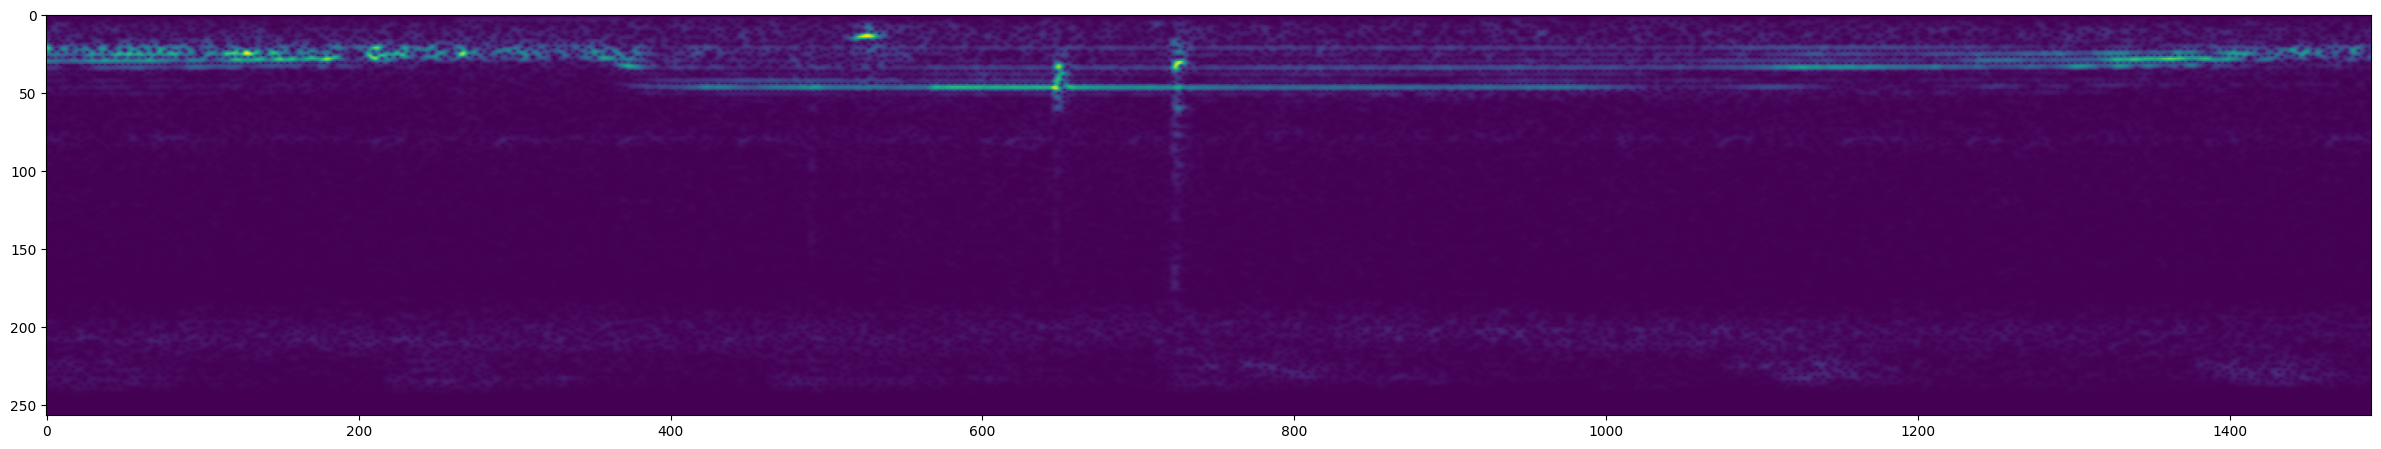

In [25]:
# Visualize
plt.figure(figsize = (30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Create training and testing partitions

In [27]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size = 1000)
data = data.batch(16)
data = data.prefetch(8)

In [ ]:
data.as_numpy_iterator().next()

In [30]:
train = data.take(36)
test = data.skip(36).take(15)

In [31]:
# Test one batch
samples, labels = train.as_numpy_iterator().next()

In [33]:
print(samples.shape)
labels

(16, 1491, 257, 1)


array([0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

# Build Deep learning model

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [37]:
model = Sequential([
    Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', input_shape = (1491, 257, 1)),
    Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu'),
    Flatten(),
    Dense(units = 128, activation = 'relu'),
    Dense(units = 1, activation = 'sigmoid'),
])

In [41]:
model.compile('Adam', loss = 'BinaryCrossentropy', metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


# Fit model, view loss and KPI plots

In [43]:
hist = model.fit(train, epochs = 4, validation_data = test)

Epoch 1/4
36/36 [==============================] - 581s 16s/step - loss: 35.6145 - recall_1: 0.8280 - precision_1: 0.7975 - val_loss: 1.9771 - val_recall_1: 0.8788 - val_precision_1: 0.8286
Epoch 2/4
36/36 [==============================] - 531s 15s/step - loss: 0.2933 - recall_1: 0.9156 - precision_1: 0.9276 - val_loss: 0.3937 - val_recall_1: 0.9828 - val_precision_1: 0.5938
Epoch 3/4
36/36 [==============================] - 530s 15s/step - loss: 0.0927 - recall_1: 0.9744 - precision_1: 0.9441 - val_loss: 0.0174 - val_recall_1: 1.0000 - val_precision_1: 0.9688
Epoch 4/4
36/36 [==============================] - 543s 15s/step - loss: 0.0166 - recall_1: 0.9801 - precision_1: 0.9867 - val_loss: 0.0122 - val_recall_1: 1.0000 - val_precision_1: 0.9855


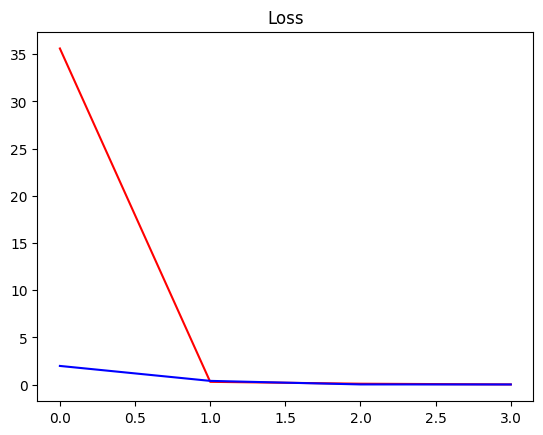

In [44]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [47]:
hist.history

{'loss': [35.61448669433594,
  0.2933118939399719,
  0.09273070842027664,
  0.016553189605474472],
 'recall_1': [0.8280254602432251,
  0.9155844449996948,
  0.9743589758872986,
  0.9801324605941772],
 'precision_1': [0.7975460290908813,
  0.9276315569877625,
  0.9440993666648865,
  0.9866666793823242],
 'val_loss': [1.9770631790161133,
  0.39372995495796204,
  0.017393527552485466,
  0.012205144390463829],
 'val_recall_1': [0.8787878751754761, 0.982758641242981, 1.0, 1.0],
 'val_precision_1': [0.8285714387893677, 0.59375, 0.96875, 0.9855072498321533]}

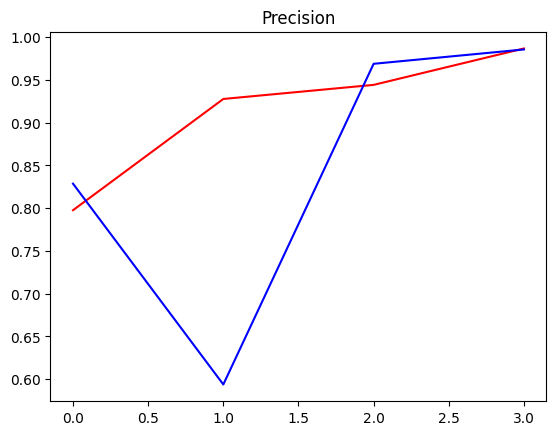

In [48]:
plt.title('Precision')
plt.plot(hist.history['precision_1'], 'r')
plt.plot(hist.history['val_precision_1'], 'b')
plt.show()

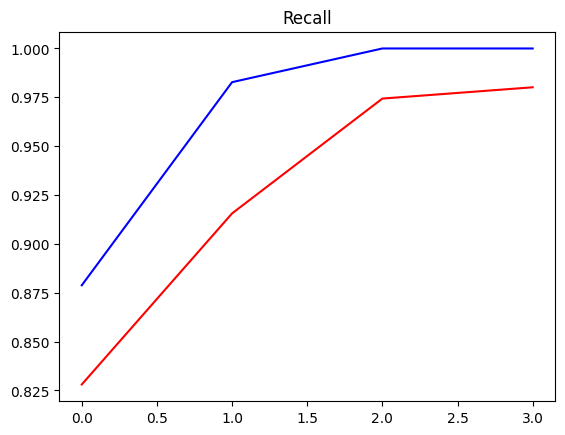

In [49]:
plt.title('Recall')
plt.plot(hist.history['recall_1'], 'r')
plt.plot(hist.history['val_recall_1'], 'b')
plt.show()

# Predictions

In [50]:
# Get one batch and make a prediction
X_test, y_test = test.as_numpy_iterator().next()

In [51]:
yhat = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [52]:
# Convert probabilities to binary labels
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

# Predict from Forest recordings data files

In [53]:
# Load up mp3s
def load_mp3_16k_mono(filename):
    res=tfio.audio.AudioIOTensor(filename)
    tensor=res.to_tensor()
    # Take the average of two channels
    tensor=tf.math.reduce_sum(tensor,axis=1)/2
    sample_rate=res.rate
    sample_rate=tf.cast(sample_rate,dtype=tf.int64)
    wav=tfio.audio.resample(tensor,rate_in=sample_rate,rate_out=16000)
    return wav

In [54]:
wav = load_mp3_16k_mono('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/recording_00.mp3')

In [55]:
# Non overlapping sequence
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [56]:
samples, index = audio_slices.as_numpy_iterator().next()

In [57]:
len(audio_slices)

60

In [58]:
samples.shape

(1, 48000)

# Convert clips to windowed spectrograms

In [59]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype = tf.float32)
    wav = tf.concat([zero_padding, sample], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [60]:
# Convert longer clips into windows and make predictions
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [67]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 [==============================] - 8s 8s/step


In [ ]:
yhat

In [69]:
# Consecutive capuchine calls should be grouped
from itertools import groupby

In [70]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()
print(calls)

5


# Loop through all files

In [71]:
results = {}
for file in os.listdir('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings'):
    FILEPATH = os.path.join('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    yhat = model.predict(audio_slices)
    results[file] = yhat

1/1 [==============================] - 6s 6s/step


In [72]:
label_preds = {}
for file, probabilities in results.items():
    label_preds[file] = [1 if prediction > 0.99 else 0 for prediction in probabilities]
label_preds

{'recording_76.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0],
 'recording_62.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_48.mp3': [0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_44.mp3': [0,
  0,
  0,
  

In [73]:
postprocessed = {}
for file, scores in label_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_76.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 'recording_62.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 'recording_48.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=4>,
 'recording_44.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 'recording_45.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 'recording_06.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 'recording_43.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 'recording_68.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=1>,
 'recording_95.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 'recording_17.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 'recording_65.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 'recording_74.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 'recording_10.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 'recording_49.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 'recording_15.mp3': <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 'recordin

# Export results

In [74]:
import csv

In [76]:
with open('results.csv', 'w', newline = '') as f:
    writer = csv.writer(f, delimiter = ',')
    writer.writerow(['recordings', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/kaggle/working/results.csv')
df.head()

In [ ]:
df = df.sort_values(by=['recordings'])

In [ ]:
df.head()

In [ ]:
df.to_csv('results1.csv', header=False, index=False)